In [1]:
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import * # A lot of the models used are here
import lightgbm as lgb
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
random.seed(1)
np.random.seed(1)

df_acc_features = pd.read_csv("../Dataprep/Electric/acc_features.csv")
df_acc_gyro_features = pd.read_csv("../Dataprep/Electric/acc_gyro_features.csv")

In [2]:
import itertools
from sklearn.metrics import confusion_matrix
# source: https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    
    
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

def model_scores(confusion_matrix):
  tn, fp, fn, tp = confusion_matrix.ravel()
  accuracy = (tp + tn) / (tp + tn + fp +fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 / ((1/precision) + (1/recall))
  fpr = fp / (fp + tn)
  print(f"Accuracy: {accuracy:.4g}\nPrecision:  {precision:.4g}\nRecall: {recall:.4g}\nF1-score: {f1_score:.4g}")
  print("-------------------------------")
  return precision, recall, fpr, f1_score

In [3]:
def train_test_split(df_in, ratio):
    df = df_in.copy()
    df = df.drop(['sampleNum'], axis=1)  # Remove sample number
    indices = df.index.copy() # Store the indices
    df = df.sample(frac=1, random_state=1)    # Shuffle the dataframe
    df.index = indices        # Reindex

    df_features = df.drop(['label'], axis=1) # Split the data into model input and output
    df_label = df['label']

    tts = int(len(df)*ratio) # train/test-split
    test_length = len(df)-tts
    train_features = df_features[:tts] 
    test_features = df_features[tts:]
    train_label = df_label[:tts]
    test_label = df_label[tts:]
    
    return train_features, test_features, train_label, test_label, test_length

def train_and_predict(train_features, train_label, test_label, test_length):
    models = [("CatBoost", CatBoostClassifier(silent=True)), 
          ("AdaBoost", AdaBoostClassifier()), 
          ("LGBM", lgb.LGBMClassifier()), 
          ("RandomForest", RandomForestClassifier(random_state=1)), 
          ("Bagging",BaggingClassifier(random_state=1)),
          ("Extra trees", ExtraTreesClassifier(random_state=1))
         ]
    N = len(models)
    predictionss = []
    cms = []
    for m in models:
        name, model = m
        model.fit(train_features, train_label)
    
        predictions = model.predict_proba(test_features)[:,1]
        predictionss.append(predictions) # Used for soft voting below
    
        predictions = model.predict(test_features)
        cm_model = confusion_matrix(test_label.values, predictions)
        print(f"Results for {name}:")
        score = model_scores(cm_model)
        cms.append((name, cm_model))
        predictions[predictions=='Normal']=0
        predictions[predictions=='Reckless']=1

    # homemade soft voting
    voting_predictions = []
    for i in range(test_length):
        pred = sum(predictionss[j][i] for j in range(N))/N
        pred = 1 if pred>0.5 else 0
        voting_predictions.append(pred)
    print("Results for Soft Voting:")
    voting_predictions = pd.Series(voting_predictions)
    voting_predictions.loc[voting_predictions==0]='Normal'
    voting_predictions.loc[voting_predictions==1]='Reckless'
    voting_predictions = voting_predictions.values
    cm_voting = confusion_matrix(test_label.values, voting_predictions)
    voting_score = model_scores(cm_voting)
    cms.append(("SoftVoting", cm_voting))
    
    # Scikit-learns hard voting
    estimators = [
              ('1', CatBoostClassifier(silent=True)), 
              ('2', AdaBoostClassifier()), 
              ('3', lgb.LGBMClassifier()), 
              ('4', RandomForestClassifier(random_state=1)), 
              ('5', BaggingClassifier(random_state=1)),
              ('6', ExtraTreesClassifier(random_state=1))
             ]

    voting = VotingClassifier(estimators, voting = 'hard')
    voting.fit(train_features, train_label)
    predictions_hard_voting = model.predict(test_features)

    cm_hard_voting = confusion_matrix(test_label.values, predictions_hard_voting)
    print("Result Hard Voting:")
    score_hard_voting = model_scores(cm_hard_voting)
    cms.append(("HardVoting", cm_hard_voting))
    
    return cms

In [8]:
train_features, test_features, train_label, test_label, test_length = train_test_split(df_acc_features.copy(), 0.8)
cms_acc = train_and_predict(train_features, train_label, test_label, test_length)

Results for CatBoost:
Accuracy: 0.966
Precision:  0.9702
Recall: 0.954
F1-score: 0.962
-------------------------------
Results for AdaBoost:
Accuracy: 0.9642
Precision:  0.9701
Recall: 0.9498
F1-score: 0.9598
-------------------------------
Results for LGBM:
Accuracy: 0.9547
Precision:  0.9654
Recall: 0.9331
F1-score: 0.9489
-------------------------------
Results for RandomForest:
Accuracy: 0.9604
Precision:  0.9698
Recall: 0.9414
F1-score: 0.9554
-------------------------------
Results for Bagging:
Accuracy: 0.9509
Precision:  0.9692
Recall: 0.9205
F1-score: 0.9442
-------------------------------
Results for Extra trees:
Accuracy: 0.966
Precision:  0.9742
Recall: 0.9498
F1-score: 0.9619
-------------------------------
Results for Soft Voting:
Accuracy: 0.966
Precision:  0.9742
Recall: 0.9498
F1-score: 0.9619
-------------------------------
Result Hard Voting:
Accuracy: 0.966
Precision:  0.9742
Recall: 0.9498
F1-score: 0.9619
-------------------------------


<Figure size 432x288 with 0 Axes>

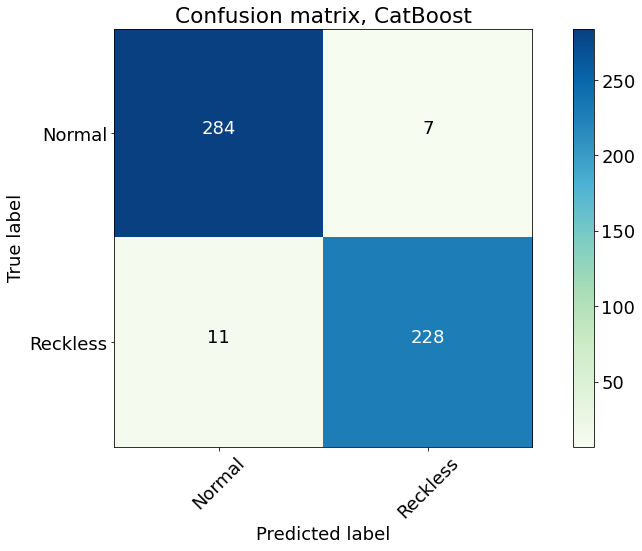

<Figure size 432x288 with 0 Axes>

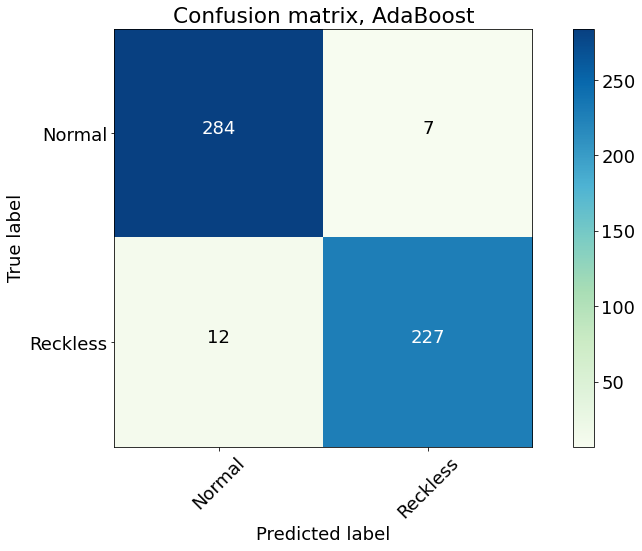

<Figure size 432x288 with 0 Axes>

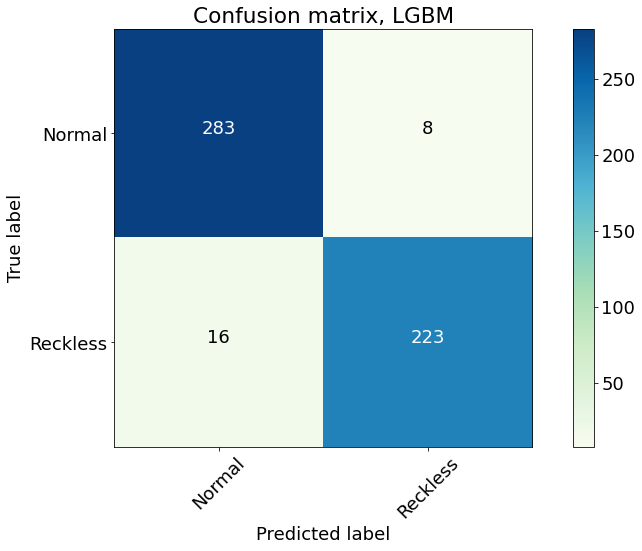

<Figure size 432x288 with 0 Axes>

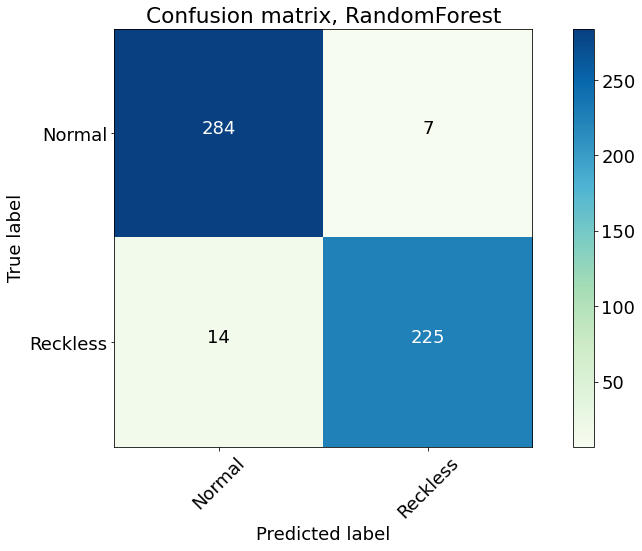

<Figure size 432x288 with 0 Axes>

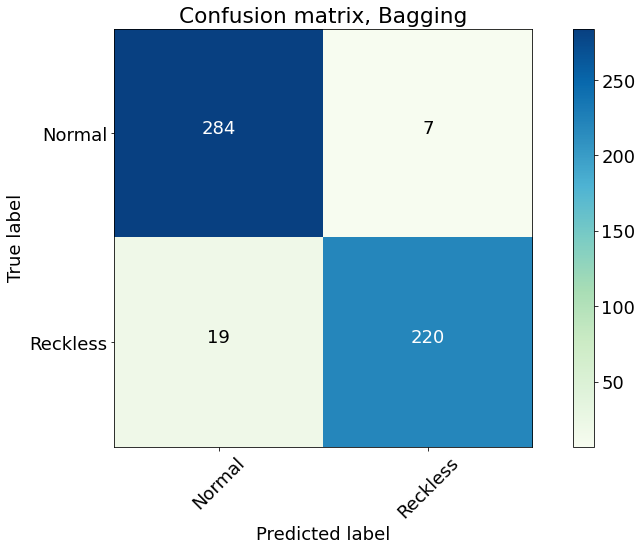

<Figure size 432x288 with 0 Axes>

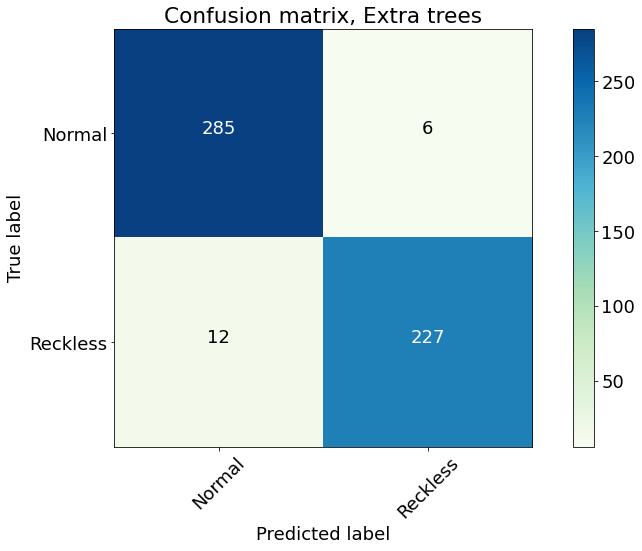

<Figure size 432x288 with 0 Axes>

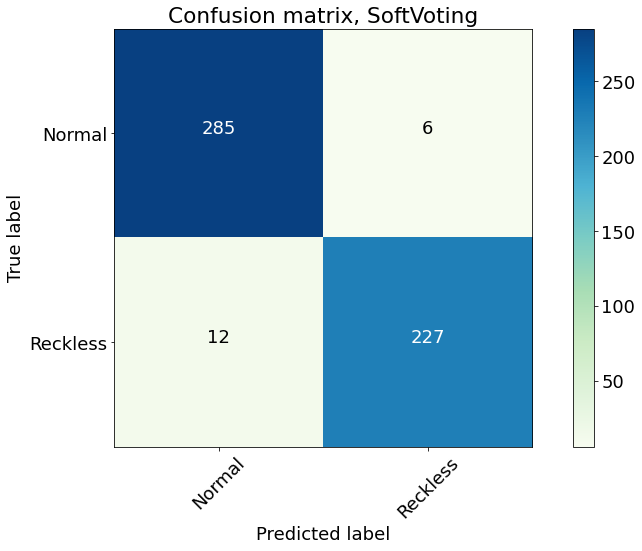

<Figure size 432x288 with 0 Axes>

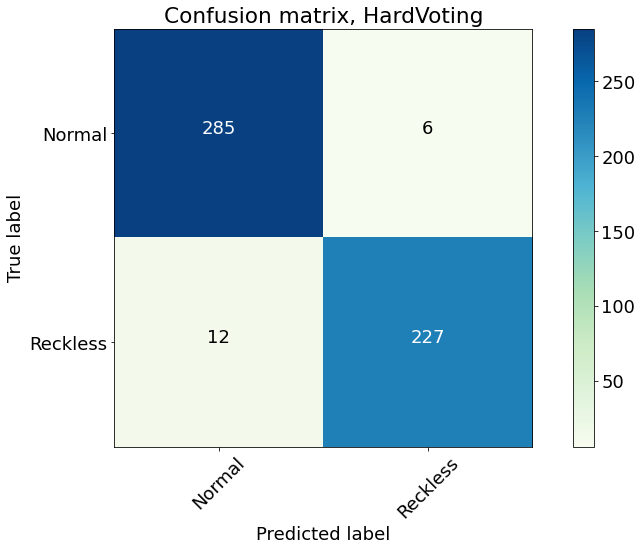

In [9]:
for row in cms_acc:
    name, cm = row
    plt.figure()
    plot_confusion_matrix(cm,
                         classes=["Normal", "Reckless"],
                         title=f"Confusion matrix, {name}",
                         cmap="GnBu")

In [5]:
train_features, test_features, train_label, test_label, test_length = train_test_split(df_acc_gyro_features.copy(), 0.8)
cms_acc_gyro = train_and_predict(train_features, train_label, test_label, test_length)

Results for CatBoost:
Accuracy: 0.9811
Precision:  0.9914
Recall: 0.9665
F1-score: 0.9788
-------------------------------
Results for AdaBoost:
Accuracy: 0.9755
Precision:  0.9913
Recall: 0.954
F1-score: 0.9723
-------------------------------
Results for LGBM:
Accuracy: 0.9717
Precision:  0.987
Recall: 0.9498
F1-score: 0.968
-------------------------------
Results for RandomForest:
Accuracy: 0.9774
Precision:  0.983
Recall: 0.9665
F1-score: 0.9747
-------------------------------
Results for Bagging:
Accuracy: 0.9755
Precision:  0.9829
Recall: 0.9623
F1-score: 0.9725
-------------------------------
Results for Extra trees:
Accuracy: 0.9811
Precision:  0.9872
Recall: 0.9707
F1-score: 0.9789
-------------------------------
Results for Soft Voting:
Accuracy: 0.9736
Precision:  0.9828
Recall: 0.9582
F1-score: 0.9703
-------------------------------
Result Hard Voting:
Accuracy: 0.9811
Precision:  0.9872
Recall: 0.9707
F1-score: 0.9789
-------------------------------


<Figure size 432x288 with 0 Axes>

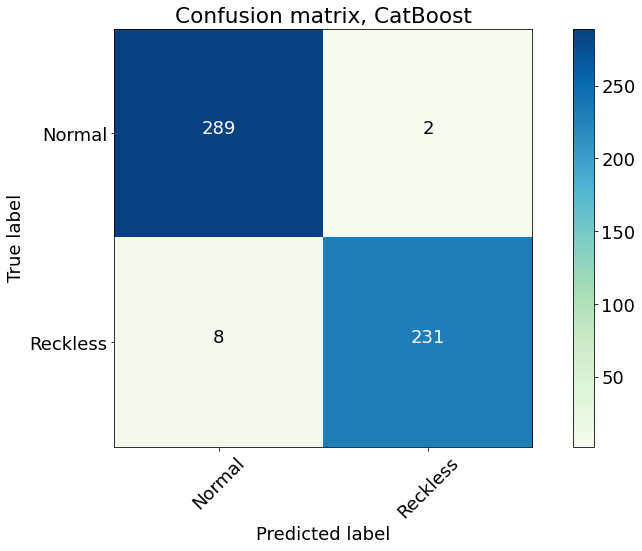

<Figure size 432x288 with 0 Axes>

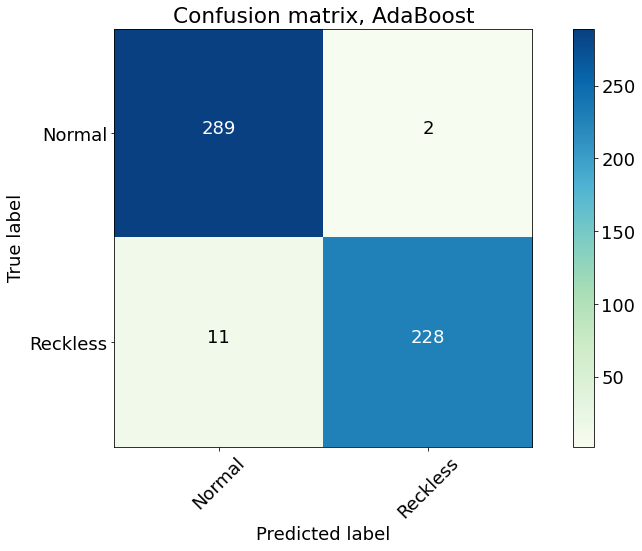

<Figure size 432x288 with 0 Axes>

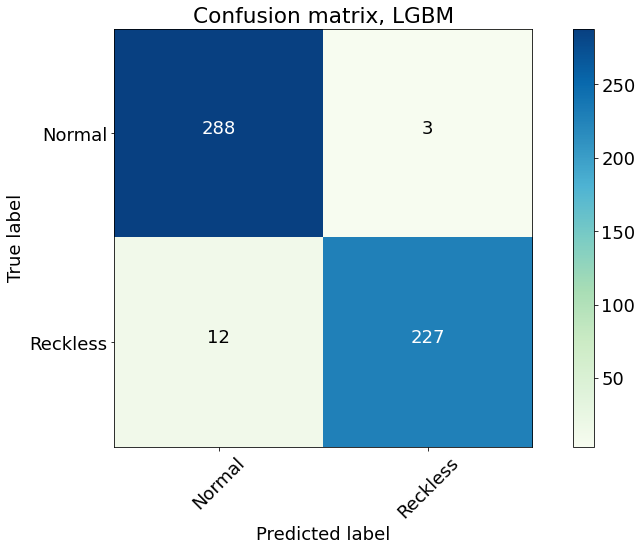

<Figure size 432x288 with 0 Axes>

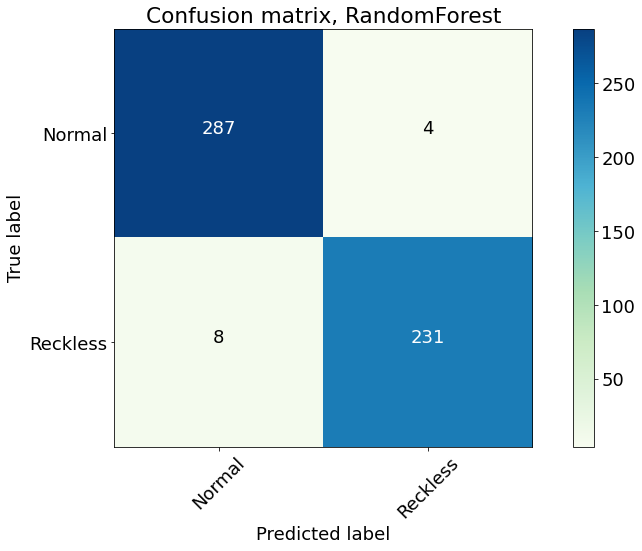

<Figure size 432x288 with 0 Axes>

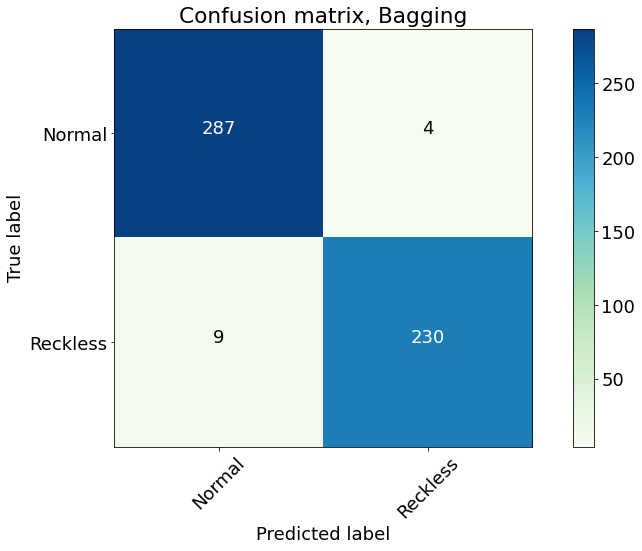

<Figure size 432x288 with 0 Axes>

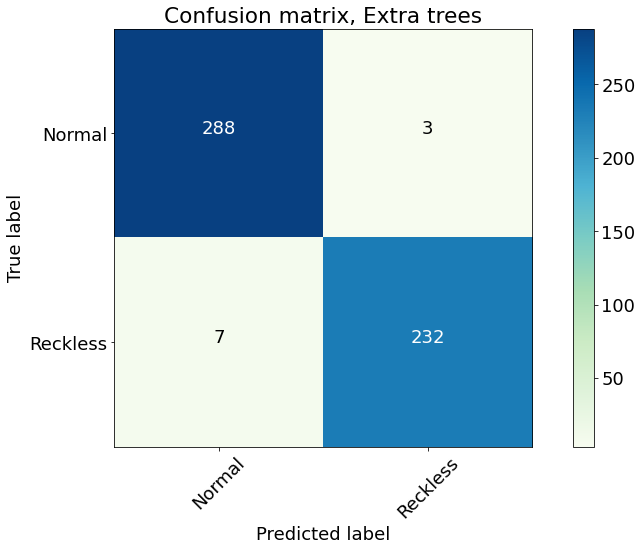

<Figure size 432x288 with 0 Axes>

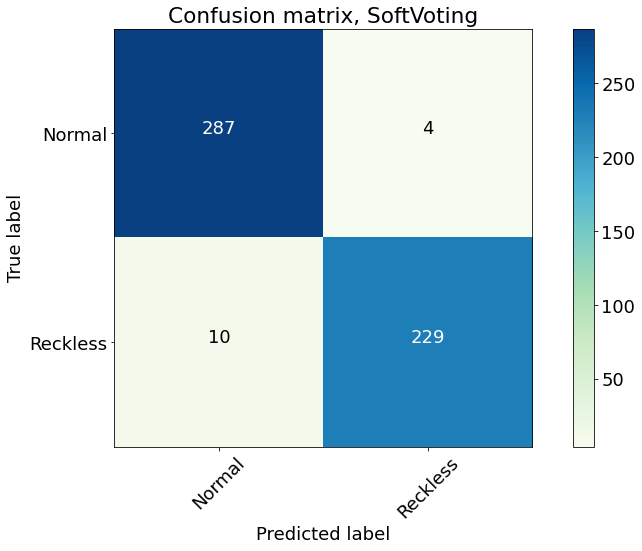

<Figure size 432x288 with 0 Axes>

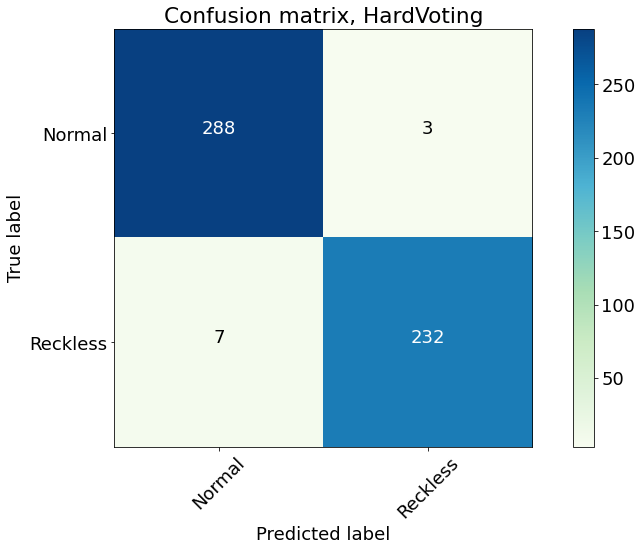

In [6]:
for row in cms_acc_gyro:
    name, cm = row
    plt.figure()
    plot_confusion_matrix(cm,
                         classes=["Normal", "Reckless"],
                         title=f"Confusion matrix, {name}",
                         cmap="GnBu")